# MLflow

[MLflow](https://mlflow.org/docs/latest/concepts.html) seeks to address these three core issues:

* It’s difficult to keep track of experiments
* It’s difficult to reproduce code
* There’s no standard way to package and deploy models

In the past, when examining a problem, you would have to manually keep track of the many models you created, as well as their associated parameters and metrics. This can quickly become tedious and take up valuable time, which is where MLflow comes in.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:<br>
* Use MLflow to track experiments, log metrics, and compare runs

**Required Libraries**: 
* `mlflow==1.7.0` via PyPI

-sandbox
<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>

In [0]:
%run "./Includes/Classroom-Setup"

Let's start by loading SF Airbnb Dataset.

In [0]:
%python
filePath = "dbfs:/mnt/training/airbnb/sf-listings/sf-listings-2019-03-06-clean.parquet/"
airbnbDF = spark.read.parquet(filePath)

(trainDF, testDF) = airbnbDF.randomSplit([.8, .2], seed=42)
print(trainDF.cache().count())

5780

### MLflow Tracking

MLflow Tracking is a logging API specific for machine learning and agnostic to libraries and environments that do the training.  It is organized around the concept of **runs**, which are executions of data science code.  Runs are aggregated into **experiments** where many runs can be a part of a given experiment and an MLflow server can host many experiments.


MLflow tracking also serves as a **model registry** so tracked models can easily be stored and, as necessary, deployed into production. This also standardizes this process, which significantly accelerates it and allows for scalability. Experiments can be tracked using libraries in Python, R, and Java as well as by using the CLI and REST calls.  This module will use Python, though the majority of MLflow functionality is also exposed in these other APIs.

### Track Runs

Each run can record the following information:<br><br>

- **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
- **Source:** The code that originally ran the experiment

**NOTE**: MLflow can only log PipelineModels.

In [0]:
!pip3 install mlflow

In [0]:
%python
import mlflow
import mlflow.spark
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

username = "pinky.gtm@mail.kmutt.ac.th"
mlflow.set_experiment(f"/Users/{username}/tr-mlflow")

with mlflow.start_run(run_name="LR-Single-Feature") as run:
  # Define pipeline
  vecAssembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
  lr = LinearRegression(featuresCol="features", labelCol="price")
  pipeline = Pipeline(stages=[vecAssembler, lr])
  pipelineModel = pipeline.fit(trainDF)
  
  # Log parameters
  mlflow.log_param("label", "price-bedrooms")
  
  # Log model
  mlflow.spark.log_model(pipelineModel, "model")
  
  # Evaluate predictions
  predDF = pipelineModel.transform(testDF)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
  rmse = regressionEvaluator.evaluate(predDF)
  
  # Log metrics
  mlflow.log_metric("rmse", rmse)

# display_run_uri(run.info.experiment_id, run.info.run_id)

Next let's build our linear regression model but use all of our features.

In [0]:
%python
from pyspark.ml.feature import RFormula
with mlflow.start_run(run_name="LR-All-Features") as run:
  # Create pipeline
  rFormula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip")
  lr = LinearRegression(labelCol="price", featuresCol="features")
  pipeline = Pipeline(stages = [rFormula, lr])
  pipelineModel = pipeline.fit(trainDF)
  
  # Log pipeline
  mlflow.spark.log_model(pipelineModel, "model")
  
  # Log parameter
  mlflow.log_param("label", "price-all-features")
  
  # Create predictions and metrics
  predDF = pipelineModel.transform(testDF)
  regressionEvaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
  rmse = regressionEvaluator.setMetricName("rmse").evaluate(predDF)
  r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
  
  # Log both metrics
  mlflow.log_metric("rmse", rmse)
  mlflow.log_metric("r2", r2)

# display_run_uri(run.info.experiment_id, run.info.run_id)

Finally, we will use Linear Regression to predict the log of the price, due to its log normal distribution.

We'll also practice logging artifacts to keep a visual of our log normal histogram.

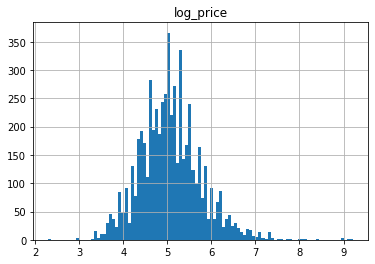

In [0]:
%python
from pyspark.ml.feature import RFormula
from pyspark.sql.functions import col, log, exp
import matplotlib.pyplot as plt

with mlflow.start_run(run_name="LR-Log-Price") as run:
  # Take log of price
  logTrainDF = trainDF.withColumn("log_price", log(col("price")))
  logTestDF = testDF.withColumn("log_price", log(col("price")))
  
  # Log parameter
  mlflow.log_param("label", "log-price")
  
  # Create pipeline
  rFormula = RFormula(formula="log_price ~ . - price", featuresCol="features", labelCol="log_price", handleInvalid="skip")  
  lr = LinearRegression(labelCol="log_price", predictionCol="log_prediction")
  pipeline = Pipeline(stages = [rFormula, lr])
  pipelineModel = pipeline.fit(logTrainDF)
  
  # Log model
  mlflow.spark.log_model(pipelineModel, "log-model")
  
  # Make predictions
  predDF = pipelineModel.transform(logTestDF)
  expDF = predDF.withColumn("prediction", exp(col("log_prediction")))
  
  # Evaluate predictions
  rmse = regressionEvaluator.setMetricName("rmse").evaluate(expDF)
  r2 = regressionEvaluator.setMetricName("r2").evaluate(expDF)
  
  # Log metrics
  mlflow.log_metric("rmse", rmse)
  mlflow.log_metric("r2", r2)
  
  # Log artifact
  plt.clf()
  logTrainDF.toPandas().hist(column="log_price", bins=100)
  figPath = username + "logNormal.png" 
  plt.savefig(figPath)
  mlflow.log_artifact(figPath)
  display(plt.show())
  
# display_run_uri(run.info.experiment_id, run.info.run_id)

That's it! Now, let's use MLflow to easily look over our work and compare model performance. You can either query past runs programmatically or use the MLflow UI.

### Querying Past Runs

You can query past runs programatically in order to use this data back in Python.  The pathway to doing this is an `MlflowClient` object.

In [0]:
%python
from mlflow.tracking import MlflowClient

client = MlflowClient()

In [0]:
%python
client.list_experiments()

Out[8]: [<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/178831629597900', experiment_id='178831629597900', lifecycle_stage='active', name='/Users/pinky.gtm@mail.kmutt.ac.th/tr-mlflow', tags={'mlflow.experiment.sourceName': '/Users/pinky.gtm@mail.kmutt.ac.th/tr-mlflow',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'pinky.gtm@mail.kmutt.ac.th',
 'mlflow.ownerId': '6858181777285753'}>]

You can also use [search_runs](https://mlflow.org/docs/latest/search-syntax.html) to find all runs for a given experiment.

In [0]:
%python
experiment_id = run.info.experiment_id
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse,metrics.r2,params.label,tags.mlflow.user,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.databricks.workspaceURL,tags.mlflow.databricks.notebookPath,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries
dbbc893332784f23b81505e76b07f5f9,178831629597900,FINISHED,dbfs:/databricks/mlflow-tracking/178831629597900/dbbc893332784f23b81505e76b07f5f9/artifacts,2022-03-09T05:49:58.984+0000,2022-03-09T05:50:53.831+0000,208.42938125656008,0.25026639574212406,log-price,pinky.gtm@mail.kmutt.ac.th,1646805054097,2763416479023374,https://adb-2763416479023374.14.azuredatabricks.net,/Users/pinky.gtm@mail.kmutt.ac.th/mlflow/1. MLflow,/Users/pinky.gtm@mail.kmutt.ac.th/mlflow/1. MLflow,LR-Log-Price,178831629597849,NOTEBOOK,"[{""artifact_path"":""log-model"",""flavors"":{""spark"":{""pyspark_version"":""3.0.1"",""model_data"":""sparkml""},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.7.5"",""data"":""sparkml"",""env"":""conda.yaml""}},""run_id"":""dbbc893332784f23b81505e76b07f5f9"",""model_uuid"":""6476d106d898480bbd2c2232bd8fbf5c"",""utc_time_created"":""2022-03-09 05:50:04.647148"",""databricks_runtime"":""7.3.x-scala2.12""}]","{""cluster_name"":""Test cluster"",""spark_version"":""7.3.x-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}",0301-183529-njlri88m,https://eastus-c3.azuredatabricks.net,"{""installable"":[],""redacted"":[]}"
2ef784895fa447f6a8eae217ce81de36,178831629597900,FINISHED,dbfs:/databricks/mlflow-tracking/178831629597900/2ef784895fa447f6a8eae217ce81de36/artifacts,2022-03-09T05:42:58.448+0000,2022-03-09T05:43:55.514+0000,220.6193376184615,0.16000586998091393,price-all-features,pinky.gtm@mail.kmutt.ac.th,1646804635711,2763416479023374,https://adb-2763416479023374.14.azuredatabricks.net,/Users/pinky.gtm@mail.kmutt.ac.th/mlflow/1. MLflow,/Users/pinky.gtm@mail.kmutt.ac.th/mlflow/1. MLflow,LR-All-Features,178831629597849,NOTEBOOK,"[{""artifact_path"":""model"",""flavors"":{""spark"":{""pyspark_version"":""3.0.1"",""model_data"":""sparkml""},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.7.5"",""data"":""sparkml"",""env"":""conda.yaml""}},""run_id"":""2ef784895fa447f6a8eae217ce81de36"",""model_uuid"":""b7b6ea9c631a488b9378fffc3034e06d"",""utc_time_created"":""2022-03-09 05:43:07.394245"",""databricks_runtime"":""7.3.x-scala2.12""}]","{""cluster_name"":""Test cluster"",""spark_version"":""7.3.x-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}",0301-183529-njlri88m,https://eastus-c3.azuredatabricks.net,"{""installable"":[],""redacted"":[]}"
5497ffc10f154eb19a2e809c104c6c38,178831629597900,FINISHED,dbfs:/databricks/mlflow-tracking/178831629597900/5497ffc10f154eb19a2e809c104c6c38/artifacts,2022-03-09T05:40:24.628+0000,2022-03-09T05:40:59.825+0000,221.62781635662907,null,price-bedrooms,pinky.gtm@mail.kmutt.ac.th,1646804460076,2763416479023374,https://adb-2763416479023374.14.azuredatabricks.net,/Users/pinky.gtm@mail.kmutt.ac.th/mlflow/1. MLflow,/Users/pinky.gtm@mail.kmutt.ac.th/mlflow/1. MLflow,LR-Single-Feature,178831629597849,NOTEBOOK,"[{""artifact_path"":""model"",""flavors"":{""spark"":{""pyspark_version"":""3.0.1"",""model_data"":""sparkml""},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.7.5"",""data"":""sparkml"",""env"":""conda.yaml""}},""run_id"":""5497ffc10f154eb19a2e809c104c6c38"",""model_uuid"":""c66f930d73b744df93d3acebfb23d76d"",""utc_time_created"":""2022-03-09 05:40:27.568928"",""dat

Pull the last run and look at metrics.

In [0]:
%python
runs = client.search_runs(experiment_id, order_by=["attributes.start_time desc"], max_results=1)
runs[0].data.metrics

Out[10]: {'r2': 0.25026639574212406, 'rmse': 208.42938125656008}

In [0]:
%python
run_id = runs[0].info.run_id
run_id
# display_run_uri(run.info.experiment_id, run_id)

Out[14]: 'dbbc893332784f23b81505e76b07f5f9'

-sandbox
Examine the results in the UI.  Look for the following:<br><br>

1. The `Experiment ID`
2. The artifact location.  This is where the artifacts are stored in DBFS.
3. The time the run was executed.  **Click this to see more information on the run.**
4. The code that executed the run.


After clicking on the time of the run, take a look at the following:<br><br>

1. The Run ID will match what we printed above
2. The model that we saved, included a pickled version of the model as well as the Conda environment and the `MLmodel` file.

Note that you can add notes under the "Notes" tab to help keep track of important information about your models. 

Also, click on the run for the log normal distribution and see that the histogram is saved in "Artifacts".

### Load Saved Model

Let's practice [loading](https://www.mlflow.org/docs/latest/python_api/mlflow.spark.html) our logged log-normal model.

In [0]:
%python

loaded_model = mlflow.spark.load_model(f"runs:/{run.info.run_uuid}/log-model")
display(loaded_model.transform(testDF))

host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,features,log_prediction
f,flexible,f,1.0,Bayview,37.72001,-122.39249,House,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,2.0,128.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 98, List(0, 3, 6, 7, 23, 43, 44, 46, 69, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.72001, -122.39249, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 128.0, 97.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0))",4.641737280652421
f,flexible,f,1.0,Bayview,37.7325,-122.39221,House,Private room,1.0,1.0,1.0,1.0,Real Bed,31.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,45.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"List(0, 98, List(0, 3, 6, 7, 23, 43, 44, 46, 70, 71, 72, 73, 74, 75, 79, 81, 82, 83, 84, 85, 86, 87, 91, 92, 93, 94, 95, 96, 97), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.7325, -122.39221, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 98.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))",4.22052009701045
f,flexible,f,1.0,Bayview,37.73555,-122.39779,House,Private room,1.0,1.0,1.0,1.0,Real Bed,30.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,70.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"List(0, 98, List(0, 3, 6, 7, 23, 43, 44, 46, 70, 71, 72, 73, 74, 75, 79, 81, 82, 83, 84, 85, 86, 87, 91, 92, 93, 94, 95, 96, 97), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.73555, -122.39779, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 98.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))",4.244383917168847
f,flexible,f,1.0,Bernal Heights,37.73905,-122.41269,Apartment,Private room,1.0,1.0,1.0,1.0,Real Bed,30.0,1.0,80.0,10.0,8.0,10.0,10.0,8.0,10.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 98, List(0, 3, 6, 7, 13, 43, 44, 45, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.73905, -122.41269, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 1.0, 80.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0))",3.893997120338156
f,flexible,f,1.0,Bernal Heights,37.74473,-122.41516,House,Private room,1.0,1.0,1.0,1.0,Real Bed,1.0,3.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,159.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 98, List(0, 3, 6, 7, 13, 43, 44, 46, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.74473, -122.41516, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 100.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0))",4.607500169174472
f,flexible,f,1.0,Bernal Heights,37.74697,-122.41193,House,Entire home/apt,3.0,1.0,2.0,2.0,Real Bed,2.0,15.0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 98, List(0, 3, 6, 7, 13, 43, 44, 46, 69, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.74697, -122.41193, 1.0, 1.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 15.0, 96.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0))",5.365478846795469
f,flexible,f,1.0,Castro/Upper Market,37.76269,-122.43188,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,30.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 98, List(0, 3, 6, 7, 12, 43, 44, 45, 69, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87), List(1.0, 1.0, 1.0, 1.0, 1.0, 37.76269, -122.43188, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 30.0, 1.0, 100.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0))",5.084003388213802
f,flexible,f,1.0,Chinatown,37.79199,-122.40704,Apartment,Entire home/apt,3.0,1.0,1.0,3.0,Real

### Log Param, Metrics, and Artifacts

Now it's your turn! Log your name, your height, and a fun [matplotlib visualization](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py) (by calling the `generate_plot` function below - feel free to modify the viz!) under a run with name `MLflow-Lab` in our new MLflow experiment.

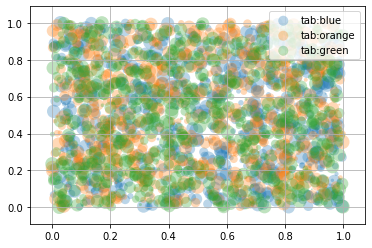

In [0]:
%python
def generate_plot():
  import numpy as np
  np.random.seed(19680801)
  import matplotlib.pyplot as plt

  fig, ax = plt.subplots()
  for color in ['tab:blue', 'tab:orange', 'tab:green']:
      n = 750
      x, y = np.random.rand(2, n)
      scale = 200.0 * np.random.rand(n)
      ax.scatter(x, y, c=color, s=scale, label=color,
                 alpha=0.3, edgecolors='none')

  ax.legend()
  ax.grid(True)
#   display(plt.show())
  return fig, plt

generate_plot()

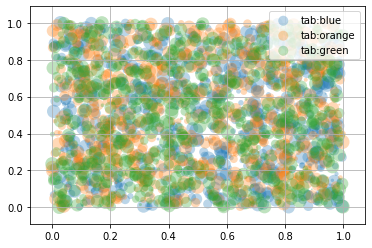

In [0]:
with mlflow.start_run(run_name="test run") as run:
  mlflow.log_param("name", "pinky")
  mlflow.log_param("h", "170")
  
  figPath = username + "random.png" 
  fig, plt = generate_plot()
  plt.savefig(figPath)
  
  mlflow.log_artifact(figPath)
  mlflow.end_run()